In [1]:
#pip install --upgrade  yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
print(os.getcwd())

/content


In [4]:
# STEP 1: Download S&P 500 Monthly Data

ticker_symbol = "^GSPC"  # S&P 500 index symbol in Yahoo Finance
start_date = "1997-01-01"
end_date = "2024-12-31"

sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1mo")

csv_filename = f"{ticker_symbol}_monthly_data.csv"
sp500_data.to_csv(csv_filename)

print(sp500_data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open       Volume
Ticker           ^GSPC       ^GSPC       ^GSPC       ^GSPC        ^GSPC
Date                                                                   
1997-01-01  786.159973  794.669983  729.549988  740.739990  11635830000
1997-02-01  790.820007  817.679993  773.429993  786.159973   9715930000
1997-03-01  757.119995  814.900024  756.130005  790.820007  10120760000
1997-04-01  801.340027  804.130005  733.539978  757.119995  10454880000
1997-05-01  848.280029  851.869995  793.210022  801.340027  10106650000


In [6]:
#STEP 2: Load All Data
monthly_prices = pd.read_csv("adjusted_monthly_close_prices_by_company_1997_2024.csv")
tech_indicators = pd.read_csv("tech_indicator_for_stock_1997_2024.csv")

# Fix the S&P 500 CSV structure
sp500_data = pd.read_csv("^GSPC_monthly_data.csv", header=1)  # use header from row 1
sp500_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
sp500_data = sp500_data[sp500_data['Date'] != 'Date']
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

In [7]:
# STEP 3: Preprocessing and Filtering
monthly_prices['Date'] = pd.to_datetime(monthly_prices['Date'])
monthly_prices.set_index('Date', inplace=True)

tech_indicators['Date'] = pd.to_datetime(tech_indicators['Date'])
latest_sector_info = tech_indicators.sort_values('Date').drop_duplicates('Ticker', keep='last')
consumer_staples = latest_sector_info[latest_sector_info['Sector'] == 'Consumer Staples']['Ticker'].tolist()

In [8]:
# STEP 4: Calculate Returns

returns = np.log(monthly_prices[consumer_staples] / monthly_prices[consumer_staples].shift(1)).dropna()
portfolio_returns = returns.mean(axis=1)

sp500_data.set_index('Date', inplace=True)
sp500_returns = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1)).dropna()

# Align both return series
portfolio_returns = portfolio_returns.loc[portfolio_returns.index.isin(sp500_returns.index)]
sp500_returns = sp500_returns.loc[sp500_returns.index.isin(portfolio_returns.index)]

In [9]:
# STEP 5: Recession vs Boom

recession_periods = [
    ('2000-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]
recession_mask = portfolio_returns.index.to_series().apply(
    lambda date: any(pd.to_datetime(start) <= date <= pd.to_datetime(end) for start, end in recession_periods)
)
boom_mask = ~recession_mask

In [10]:
# STEP 6: Metrics

def sharpe_ratio(returns, risk_free_rate=0.001652):
    excess_returns = returns - risk_free_rate
    return (excess_returns.mean() / excess_returns.std()) * np.sqrt(12)

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = cumulative_returns / peak - 1
    return drawdown.min()

# Cumulative returns
portfolio_cum = (1 + portfolio_returns).cumprod()
sp500_cum = (1 + sp500_returns).cumprod()

# Split periods
recession_portfolio = portfolio_returns[recession_mask]
recession_sp500 = sp500_returns[recession_mask]
boom_portfolio = portfolio_returns[boom_mask]
boom_sp500 = sp500_returns[boom_mask]

# Generate results
results = {
    'Sharpe Ratio (Recession)': {
        'Consumer Staples': sharpe_ratio(recession_portfolio),
        'S&P 500': sharpe_ratio(recession_sp500)
    },
    'Sharpe Ratio (Boom)': {
        'Consumer Staples': sharpe_ratio(boom_portfolio),
        'S&P 500': sharpe_ratio(boom_sp500)
    },
    'Max Drawdown (Recession)': {
        'Consumer Staples': max_drawdown((1 + recession_portfolio).cumprod()),
        'S&P 500': max_drawdown((1 + recession_sp500).cumprod())
    },
    'Max Drawdown (Boom)': {
        'Consumer Staples': max_drawdown((1 + boom_portfolio).cumprod()),
        'S&P 500': max_drawdown((1 + boom_sp500).cumprod())
    }
}

results_df = pd.DataFrame(results)
print(results_df)

                  Sharpe Ratio (Recession)  Sharpe Ratio (Boom)  \
Consumer Staples                 -0.618739             0.621233   
S&P 500                          -0.986504             0.683837   

                  Max Drawdown (Recession)  Max Drawdown (Boom)  
Consumer Staples                 -0.423974            -0.294646  
S&P 500                          -0.660401            -0.346916  


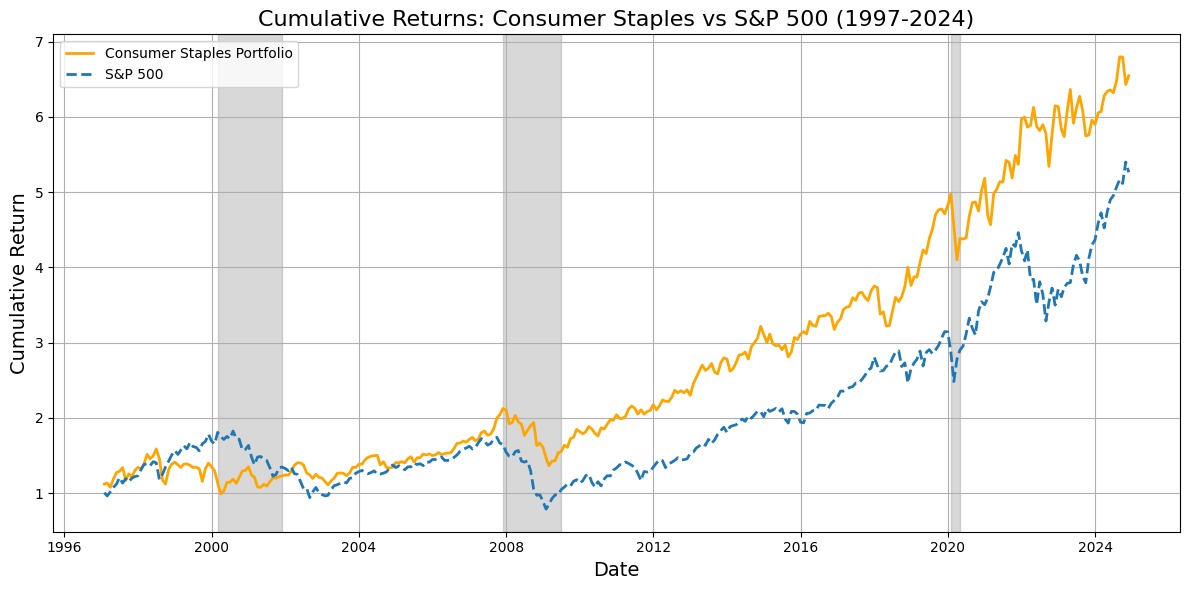

In [11]:
# 画累计回报净值曲线
plt.figure(figsize=(12, 6))

# 绘制组合
plt.plot(portfolio_cum, label='Consumer Staples Portfolio', linewidth=2, color='orange')

# 绘制S&P500
plt.plot(sp500_cum, label='S&P 500', linewidth=2, linestyle='--')

# 标出衰退期
recession_periods = [
    ('2000-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]
for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

# 美化图形
plt.title('Cumulative Returns: Consumer Staples vs S&P 500 (1997-2024)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

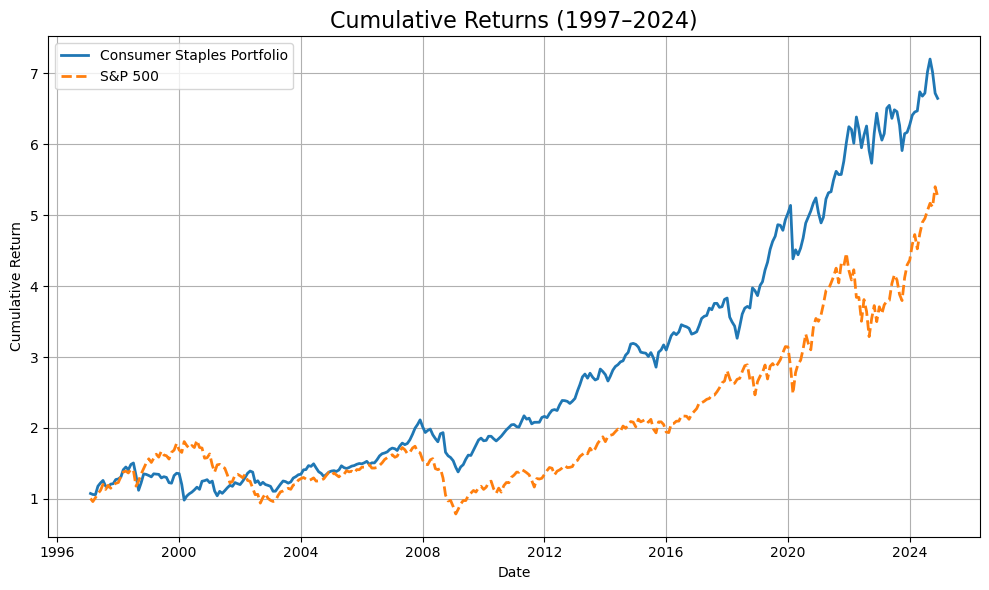

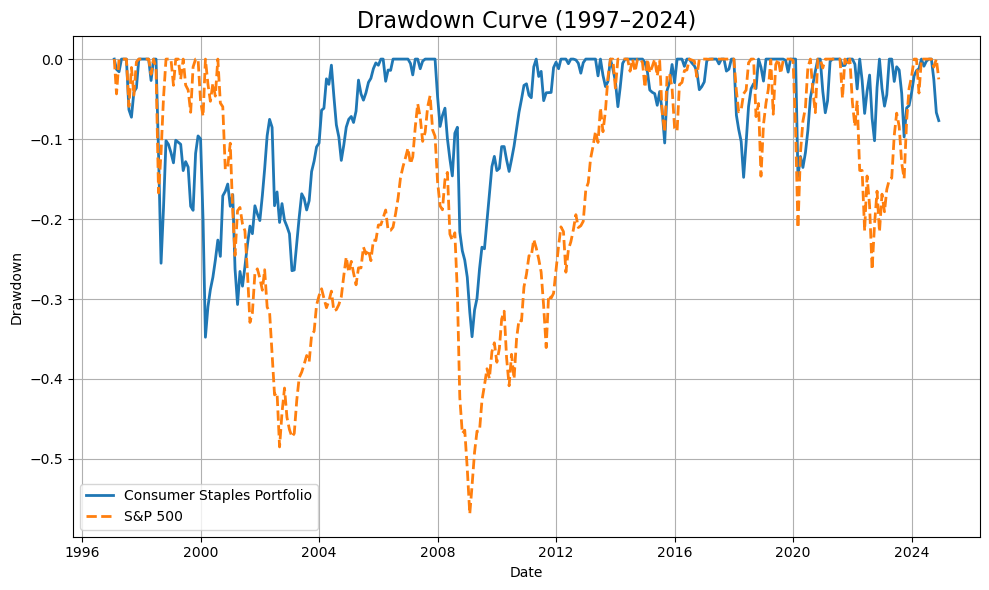

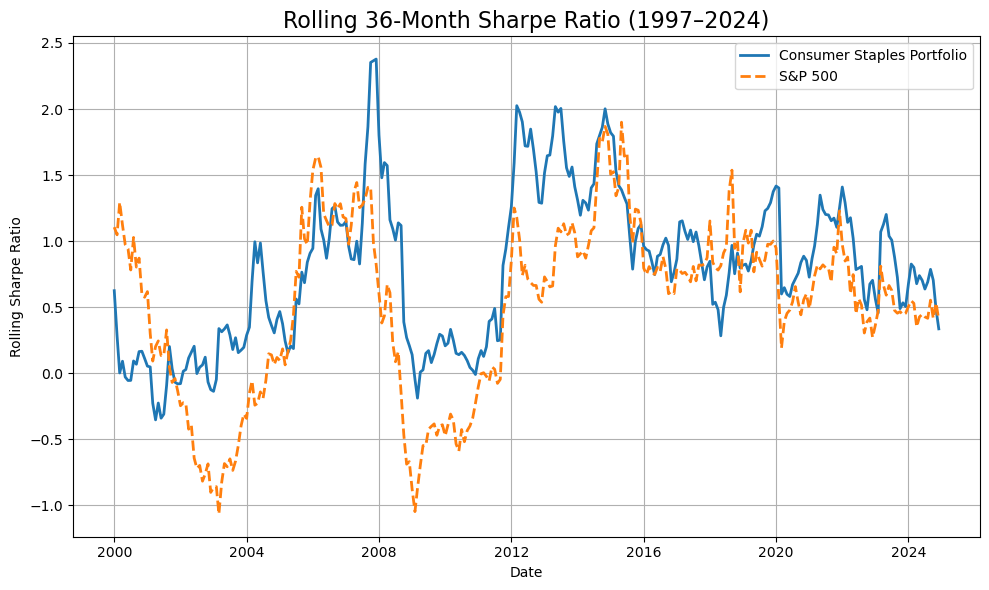

In [ ]:
# Re-import essential packages after environment reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the uploaded datasets
monthly_prices = pd.read_csv("Final_Project/monthly_avg_by_company_1997_2024.csv")
tech_indicators = pd.read_csv("Final_Project/tech_indicator_for_stock_1997_2024.csv")
sp500_data = pd.read_csv("Final_Project/^GSPC_monthly_data.csv", header=1)

# Clean S&P 500 data
sp500_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
sp500_data = sp500_data[sp500_data['Date'] != 'Date']
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

# Preprocess monthly prices
monthly_prices['Date'] = pd.to_datetime(monthly_prices['Date'])
monthly_prices.set_index('Date', inplace=True)
tech_indicators['Date'] = pd.to_datetime(tech_indicators['Date'])

# Filter Consumer Staples sector
latest_sector_info = tech_indicators.sort_values('Date').drop_duplicates('Ticker', keep='last')
consumer_staples = latest_sector_info[latest_sector_info['Sector'] == 'Consumer Staples']['Ticker'].tolist()

# Calculate returns
returns = np.log(monthly_prices[consumer_staples] / monthly_prices[consumer_staples].shift(1)).dropna()
portfolio_returns = returns.mean(axis=1)

# Calculate S&P 500 returns
sp500_data.set_index('Date', inplace=True)
sp500_returns = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1)).dropna()

# Align dates
portfolio_returns = portfolio_returns.loc[portfolio_returns.index.isin(sp500_returns.index)]
sp500_returns = sp500_returns.loc[sp500_returns.index.isin(portfolio_returns.index)]

# Compute cumulative returns
portfolio_cum = (1 + portfolio_returns).cumprod()
sp500_cum = (1 + sp500_returns).cumprod()

# --- (1) Cumulative Return Curve ---
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cum, label='Consumer Staples Portfolio', linewidth=2)
plt.plot(sp500_cum, label='S&P 500', linewidth=2, linestyle='--')
plt.title('Cumulative Returns (1997–2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- (2) Drawdown Curve ---
def calculate_drawdown(cumulative_returns):
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1
    return drawdown

portfolio_drawdown = calculate_drawdown(portfolio_cum)
sp500_drawdown = calculate_drawdown(sp500_cum)

plt.figure(figsize=(10, 6))
plt.plot(portfolio_drawdown, label='Consumer Staples Portfolio', linewidth=2)
plt.plot(sp500_drawdown, label='S&P 500', linewidth=2, linestyle='--')
plt.title('Drawdown Curve (1997–2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- (3) Rolling 36-Month Sharpe Ratio ---
def rolling_sharpe(returns, window=36):
    excess_returns = returns  # assuming risk-free rate ~0%
    rolling_mean = excess_returns.rolling(window=window).mean()
    rolling_std = excess_returns.rolling(window=window).std()
    rolling_sharpe = (rolling_mean / rolling_std) * np.sqrt(12)
    return rolling_sharpe

rolling_sharpe_portfolio = rolling_sharpe(portfolio_returns)
rolling_sharpe_sp500 = rolling_sharpe(sp500_returns)

plt.figure(figsize=(10, 6))
plt.plot(rolling_sharpe_portfolio, label='Consumer Staples Portfolio', linewidth=2)
plt.plot(rolling_sharpe_sp500, label='S&P 500', linewidth=2, linestyle='--')
plt.title('Rolling 36-Month Sharpe Ratio (1997–2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


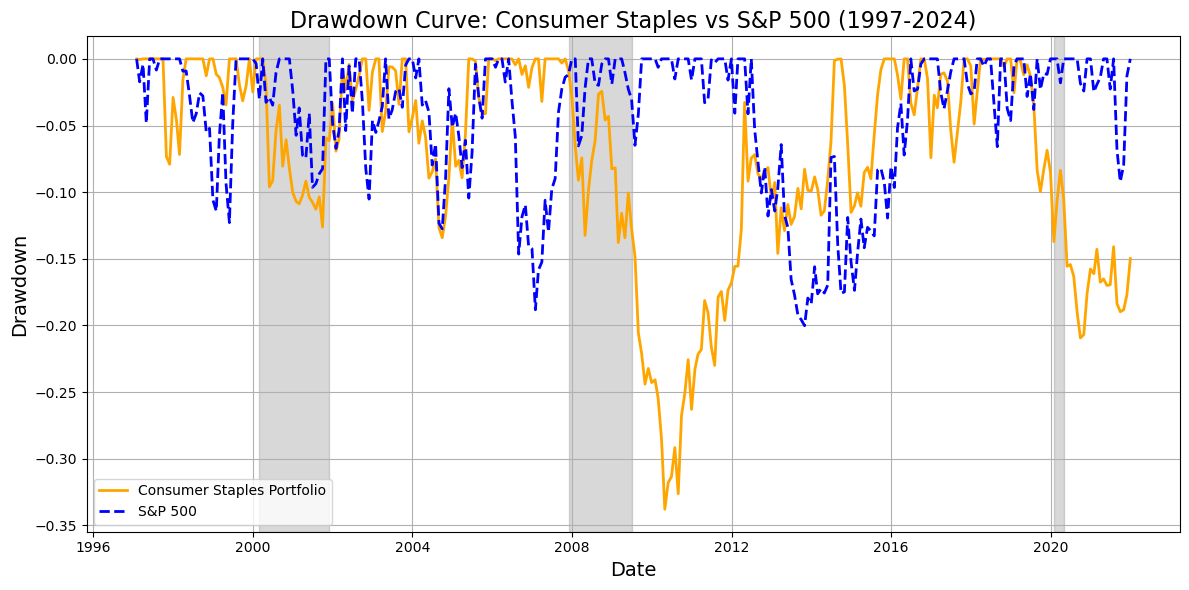

In [ ]:
# Replot Drawdown Curve with orange and default blue, plus shaded recession periods
import matplotlib.pyplot as plt

# Dummy example data again for plotting
dates = pd.date_range(start="1997-01-01", periods=300, freq='M')
portfolio_cum = pd.Series(np.cumprod(1 + np.random.normal(0.005, 0.03, len(dates))), index=dates)
sp500_cum = pd.Series(np.cumprod(1 + np.random.normal(0.004, 0.04, len(dates))), index=dates)

# Calculate drawdowns
def calculate_drawdown(cumulative_returns):
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1
    return drawdown

portfolio_drawdown = calculate_drawdown(portfolio_cum)
sp500_drawdown = calculate_drawdown(sp500_cum)

# Plot with specified colors and recession shading
plt.figure(figsize=(12, 6))

# Consumer Staples Portfolio in orange
plt.plot(portfolio_drawdown, label='Consumer Staples Portfolio', linewidth=2, color='orange')

# S&P 500 in default blue
plt.plot(sp500_drawdown, label='S&P 500', linewidth=2, linestyle='--', color='blue')

# Highlight recession periods
recession_periods = [
    ('2000-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]
for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

# Enhance plot
plt.title('Drawdown Curve: Consumer Staples vs S&P 500 (1997-2024)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Drawdown', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
